# CoViD-19 FAQ Search Engine 2.0
As promised I deliver here a new improved jedi edition with some minor NLP-lessons inserted as we go, be ready to learn new (or old) things!  
Previously I added some requirements and I want them to stay true, here they are as a refresher:

- The end-product must be unsupervised
  - No manually annotated data
  - No heuristic applied (i.e. understand the data and improve result by applying domain-specific knowledge on the task)
- It should be light enough to run on a Raspberry Pi later on (hopefully on the JVM to keep it simple with my back-end)
- Must be Swedish all the way through - no translations (English models you can transfer knowledge from tends to be stronger, but I want to keep this fun!)

These are mainly here to keep it fun and a bit challenging from a different point of view than getting State of the Art on the task at hands, rather it's to be applicable and light!  
With that in mind, let's continue on the implementation from previously!

## Improvements to be done

In the previous [blog](https://londogard.com/blog/4) & [notebook](https://colab.research.google.com/github/londogard/nlp-projects/blob/master/python/CoViD_19_QA.ipynb) I first implemented a basic FAQ search based on finding the nearest neighbour from the embedded sentences, in the end I used _Smooth Inverse Frequency Embeddings_ ([A Simple but Tough-to-Beat Baseline for Sentence Embeddings](https://openreview.net/forum?id=SyK00v5xx)) to embed the sentence which is an improvement from simply averaging the embeddings of the words in the sentence.  
I also promised to deliver some small improvements based by grabbing some low hanging fruits, the first one being lower-casing the text. Further it is worth trying lemmatizing, using a better tokenization and stop-words. In total I figured the following worthy of checking out:

- Lowercase
- Better tokenization
- Lemmatizing
- Custom features (e.g. found a swear-word etc?)
- Stop words
- Ngram & Custom Embeddings (will not be done)

To improve further I'd say that either A) _a lot_ of time to understand the data in depth and apply heuristics or B) a _supervised_ approach, which in turn require labeled data (a.k.a sweet valued time). A larger dataset would also be helpful.  
All which I don't have currently.

## Re-adding the old code
First I'll add the code from "part one" and it'll not be commented as it has been walked through.  
Further I've removed the download & parsing of FAQ, now the data is directly downloaded as a `tsv`-file allowing us to skip some libraries / code-cells.  
Some new dependencies are also added, e.g. `stanza` which is Stanfords new NLP-lib in Python (inspired by `spaCy`).

In [ ]:
%%capture
!pip install gensim --upgrade
!pip install -U fse
!pip install stanza
!pip install stop-words

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()

from pathlib import Path

import os
import random 
import operator 
import regex as re

# gensim + fasttext
from gensim.models.fasttext import FastText, load_facebook_vectors
from gensim.models import KeyedVectors

from stop_words import get_stop_words # stop-words from basically all languages

import stanza

from fse import IndexedList
from fse.models import uSIF
from fse.models.average import FAST_VERSION, MAX_WORDS_IN_BATCH
print(MAX_WORDS_IN_BATCH)
print(FAST_VERSION)

10000
1


In [ ]:
# Download models etc
stanza.download('sv', logging_level='ERROR')
print("Please download the Swe fastText model & the CoViD FAQ data from links in this code cell!")
# Swe fastText reduced dimensions -->   https://drive.google.com/open?id=1vaWtiSlRAZ3XCdtnSce_6dwQ0T5x0OEJ
# CoViD FAQ data -->                    https://github.com/londogard/nlp-projects/blob/master/datasets/covid.tsv

#### Loading all the models
This might take a little while, even though the dimensions are reduced the model is pretty large.

In [2]:
ft_wv = load_facebook_vectors('~/git/nlp-projects/models/cc.sv.100.bin')
df = pd.read_csv('~/git/nlp-projects/datasets/covid.tsv', sep='\t')
nlp = stanza.Pipeline(lang='sv', processors='tokenize', logging_level='ERROR')
model = uSIF(ft_wv, workers=4, lang_freq="sv")

flatten = lambda l: [item for sublist in l for item in sublist] # Helper function to flatten a list

## Going forward
Let's get on to adding our improvements


### 1. Tokenization & lower-case
The first and forthmost improvement is to lowercase the text and then tokenize it using a better method of tokenization.  
Let's take a look at how _stanza_ helps us out by applying a much better tokenization.

In [3]:
q = "Hej där borta! Jag känner igen dig, Johan's kompis? Eller är det Johannas?"
stanza_tokenize = lambda x: [token.text for sentence in nlp(x).sentences for token in sentence.tokens]
prev = q.split()
new = stanza_tokenize(q)

print(f"Previously:\t{prev[:12]}..")
print(f"After:\t\t{new[:12]}..")

Previously:	['Hej', 'där', 'borta!', 'Jag', 'känner', 'igen', 'dig,', "Johan's", 'kompis?', 'Eller', 'är', 'det']..
After:		['Hej', 'där', 'borta', '!', 'Jag', 'känner', 'igen', 'dig', ',', 'Johan', "'", 's']..


**So, what are we looking at?**  
Stanza handled our tokenization and increased the number of tokens, can this really be good!?  
Yes! Keep calm and don't jump the ship yet, the increased number of tokens will be followed by a decrease of unique tokens, and indirectly out of vocobulary (OOV) tokens. Unlike what we set out to do we still don't lower-case the output, this will follow later, now let me explain what the tokenization helps us achieve:

1. Punctuation, e.g. \[!,?..], is tokenized into its own token.
2. Some compound words are split up, e.g. _Johan's_ is now _Johan_, _'_, _s_ which is three (3) separate tokens rather than one.

Because of the updated tokenization _fredag_ and _fredag!_ is now tokenized as _fredag_ and \[_fredag_, _!_], this in fact turns _fredag_ into the same token in both thus achieving the same vector when embedded which is great, because it really means the same. The exclamation mark itself also applies the same meaning to all places it's applied, which in itself is an improvement now also as we embed it separately. 

**Why is this good?**  
Even though we see a direct increase in number of tokens we see a **decrease** of number of unique tokens because we now tokenize _borta_, _borta?_, & _borta!_ as the same token, with one additional for the punctuation in the two latter cases rather than 3 separate tokens which would map to different data.  
The coverage of our Word Embeddings also increase because we now tokenize the text better. Perhaps _borta!_ does not exist but _borta_ surely do exist in the embedding dictionary / lookup.   

In [4]:
# A bit ugly, that's what happens when you're lazy
def test_dimensions(preprocessing=[stanza_tokenize]):
    prev = flatten(df['question'].apply(lambda x: x.split()).tolist())
    post = flatten(df['question'].apply(lambda x: preprocess(x, preprocessing)).tolist())

    print(f"Previously: {len(prev)} tokens ({len(set(prev))} unique)")
    print(f"Post: {len(post)} tokens ({len(set(post))} unique)")
    print(f"Token reduction by ~{100 * (1- len(set(post))/len(set(prev))):.1f} %")
    labels = ['#Tokens', '#Unique Tokens']
    width = 0.35
    x = np.arange(len(labels))
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, [len(prev), len(set(prev))], width, label='Before')
    rects2 = ax.bar(x + width/2, [len(post), len(set(post))], width, label='After')
    ax.set_ylabel('Tokens')
    ax.set_title('Tokens before and after')
    ax.set_xticklabels(labels)
    ax.set_xticks(x)
    ax.legend()
    fig.tight_layout()

    plt.show()

# preprocessing is a list of lambda functions to apply
def preprocess(text, preprocessing):
    for f in preprocessing:
        text = f(text)
    return text

Let's take a look how much this actually mattered!

Previously: 629 tokens (289 unique)
Post: 713 tokens (273 unique)
Token reduction by ~5.5 %


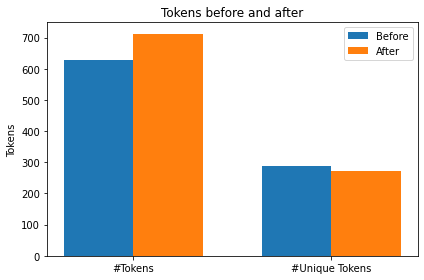

In [5]:
test_dimensions()

The expectations set up has been achieved and we can clearly see that the raw number of tokens grew while the unique token count shrinked.  
Applying lower-case to the text will further reduce the number of unique tokens, and obviously keep the number of tokens at the same count.

Let's add lower-casing and see what happens!

Previously: 629 tokens (289 unique)
Post: 712 tokens (260 unique)
Token reduction by ~10.0 %


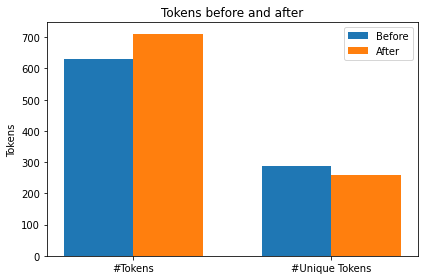

In [7]:
lowercase = lambda x: x.lower()
preprocess_funcs = [lowercase, stanza_tokenize]
test_dimensions(preprocessing=preprocess_funcs)

#### Lower-casing
Going from 5.5 to 10 % reduction is nothing to sneeze at, by applying these two simple techniques we now have the same data in a better format which allows us to have a lower number of unique tokens.  
Pretty awesome right?

Let's get on with this and apply the preprocessing to the questions and test it out with the FAQ-search!

In [8]:
df['X'] = df['question'].apply(lambda x: preprocess(x, preprocess_funcs))
df['X'].head()

0                            [vad, är, coronavirus, ?]
1                               [vad, är, covid-19, ?]
2    [vad, skiljer, covid-19, från, säsongsinfluens...
3               [vilka, är, symtomen, på, covid-19, ?]
4    [hur, vet, jag, om, mina, symtom, beror, på, p...
Name: X, dtype: object

### Testing the new input-data
Now that we've created our input data we need to test our model on this!  
By applying the `IndexedList` which is the dataformat `SFE` wants as input we can train the model and then test it.

In [9]:
sfe_format = IndexedList(df['X'].tolist())
model.train(sfe_format)

2020-06-09 09:31:15 WARNING: The embeddings will likely not fit into RAM. Consider to use mapfile_path


(75, 712)

In [10]:
# Helper method to test the closest questions
def get_n_closest_questions(question, preprocessing, n=4):
    q_fixed = preprocess(question, preprocessing)
    resp = model.sv.similar_by_sentence(q_fixed, model=model, indexable=df['question'].tolist()) # [([tokens], score)]
    resp = [f'{result[2]:.2f}: {result[0]}' for result in resp]
    print('\n'.join(resp[:n]))

In [11]:
get_n_closest_questions("kan min hamster bli smittad?", preprocess_funcs)

0.67: Kan man bli smittad av en person som har covid-19 men som inte har några symtom?
0.63: Kan covid-19 smitta mellan djur och människa och kan mitt husdjur smittas av viruset?
0.53: Kan viruset smitta till människa via post och paket?
0.43: Kan smitta överföras från mygg till människa?


In [12]:
get_n_closest_questions("Hur får jag min son att förstå?", preprocess_funcs)

0.80: Hur pratar man med barn om det nya coronaviruset?
0.77: Vad är covid-19?
0.75: Hur sjuk blir man av covid-19?
0.74: Hur länge är man sjuk av covid-19?


### Further improvements - Lemmatization and Stop Words
Let's try to further improve this by actually lemmatizing and applying stop-words!

#### Lemmatization
So what is Lemmatization? I'll take the Stanford description straight off as it's very simple and straight-forward:

> For grammatical reasons, documents are going to use different forms of a word, such as organize, organizes, and organizing. Additionally, there are families of derivationally related words with similar meanings, such as democracy, democratic, and democratization. In many situations, it seems as if it would be useful for a search for one of these words to return documents that contain another word in the set.

>  The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form. For instance: 

```
     am, are, is => be
     car, cars, car's, cars' => car 
```
> The result of this mapping of text will be something like:
```
     the boy's cars are different colors =>
     the boy car be differ color 
```

#### What is stop-words?
Stop-words are words we want to throw away as they add no real purpose. In older Machine Learning approaches it was way more important to add stop-words but in newer Deep Learning with Neural Networks stop-words often can be a negative thing, removing understanding of the sentence and perhaps minor differences which makes the world for understanding.

A example of a stop-word list could be `["hej", "vem", "då", "och", ...]` which means that these words would be removed from a sentence.

In our case it makes sense to remove words like 'vad', 'varför'  and so on because the return of the FAQ seems to be very weighted towards these words.

In [19]:
nlp = stanza.Pipeline(lang='sv', processors='tokenize,mwt,pos,lemma', logging_level='ERROR')
stanza_lemma = lambda x: [token.lemma for sentence in nlp(x).sentences for token in sentence.words]
preprocess_funcs_lemma = [lowercase, stanza_lemma]

print(f'Previously:\t{preprocess("hur förklarar jag för min dotter och son?", preprocess_funcs)}')
print(f'After:\t\t{preprocess("hur förklarar jag för min dotter och son?", preprocess_funcs_lemma)}')

Previously:	['hur', 'förklarar', 'jag', 'för', 'min', 'dotter', 'och', 'son', '?']
After:		['hur', 'förklara', 'jag', 'för', 'jag', 'dotter', 'och', 'son', '?']


**Some interesting notes**  
Seeing _min_ getting converted to _jag_ is both good and bad, in this case we reduce dimensionality of the problem but we loose context and understanding. _jag_ and _min_ certainly does not mean the same thing.

Let's see how it pans out...

Previously: 629 tokens (289 unique)
Post: 712 tokens (228 unique)
Token reduction by ~21.1 %


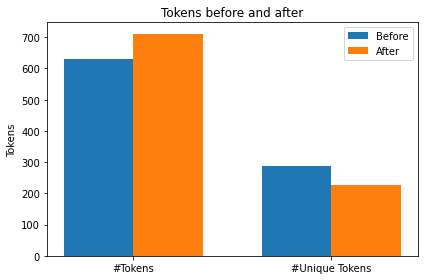

In [20]:
test_dimensions(preprocess_funcs_lemma)

In [21]:
del model
model = uSIF(ft_wv, workers=4, lang_freq="sv")
df['X'] = df['question'].apply(lambda x: preprocess(x, preprocess_funcs_lemma))
sfe_format = IndexedList(df['X'].tolist())

model.train(sfe_format)

2020-06-09 14:16:22 WARNING: The embeddings will likely not fit into RAM. Consider to use mapfile_path


(75, 712)

In [22]:
get_n_closest_questions("kan min hamster bli smittad?", preprocess_funcs_lemma)

0.75: Kan covid-19 smitta mellan djur och människa och kan mitt husdjur smittas av viruset?
0.69: Hur smittar covid-19?
0.68: Kan man smittas flera gånger av det nya coronaviruset?
0.63: Smittar covid-19 via vatten och mat?


In [23]:
get_n_closest_questions("Hur får jag min son att förstå?", preprocess_funcs_lemma)

0.79: Vad är covid-19?
0.75: Hur sjuk blir man av covid-19?
0.74: Hur länge är man sjuk av covid-19?
0.66: Om en person i familjen är sjuk - måste alla stanna hemma då?


#### Analyzing the results

**Improvements?** Not really, the model has an improved response to the 'hamster-question' but it's way off when asking about the son.  
**Why?** The most likely explanation is that even though we reduce the input dimensions an awful lot we remove dimensions that brings value, and removing value is bad - just as was touched upon previously. It might be helpful in some cases, perhaps this could prove helpful for a supervised approach such as TF-IDF + Support Vector Machine.  
**Any good parts?** Yes, we can see some pretty hefty memory-requirement reductions when working with other types of models by applying this. Actually, in the case of this we could reduce the memory requirement by lemmatizing the dictionary of the embeddings and removing all non-lemmas. All in all, this could lead to a small performance loss but great memory win.

#### Stop words

As promised we shall apply stop-words, but as we saw no performance gain with lemmatization we'll keep the old tokenization.

In [24]:
stop_words = get_stop_words('sv')
clean_stop = lambda x: [word for word in x if word not in stop_words]
preprocessing_func_stop = [lowercase, stanza_tokenize, clean_stop]

del model
model = uSIF(ft_wv, workers=4, lang_freq="sv")
df['X'] = df['question'].apply(lambda x: preprocess(x, preprocessing_func_stop)) # We don't need to remove stop-words in the sentences in our 
sfe_format = IndexedList(df['X'].tolist())

model.train(sfe_format)

preprocess("hur förklarar jag för min dotter och son?", preprocessing_func_stop)

2020-06-09 14:21:48 WARNING: The embeddings will likely not fit into RAM. Consider to use mapfile_path


['förklarar', 'dotter', 'son', '?']

Previously: 629 tokens (289 unique)
Post: 417 tokens (206 unique)
Token reduction by ~28.7 %


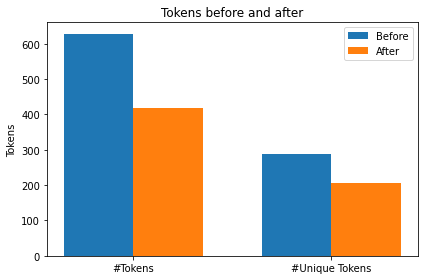

In [25]:
test_dimensions(preprocessing_func_stop)

In [26]:
get_n_closest_questions("kan min hamster bli smittad?", preprocessing_func_stop)

0.54: Vad gäller för mig som blivit frisk från covid-19?
0.53: Hur länge är man sjuk av covid-19?
0.53: Hur sjuk blir man av covid-19?
0.43: Bör jag som  symtomfri jobba hemma?


In [27]:
get_n_closest_questions("Hur får jag min son att förstå?", preprocessing_func_stop)

0.83: Vad är covid-19?
0.83: Hur pratar man med barn om det nya coronaviruset?
0.80: Hur sjuk blir man av covid-19?
0.80: Hur länge är man sjuk av covid-19?


#### Further analyzing
Stop-words showed to be almost, or even, worse than lemmatization... But I wouldn't call this a set-back.   
Currently we're simply trying different approaches and aim to find something that sticks.
This is a way to not only gather greater data understanding but also how to simply improve. Just like the agile process Machine Learning is also circular and iterative, [CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) is one of the more famous processes. CRISP-DM does display this circular workflow where you iteratively learn the data and apply better techniques until satisfied.  
![CRISP-DM](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/220px-CRISP-DM_Process_Diagram.png)

Finally, as we see no great impact by applying either lemmatization nor stop-words we might just give up at the lower-case + stanza tokenization, but I'd like to make one last shot in the dark - custom stop words! Let's see how it fares...

In [35]:
from collections import Counter

df['X'] = df['question'].apply(lambda x: preprocess(x, preprocess_funcs))

counter = Counter(flatten(df['X'].tolist()))

In [56]:
sorted(counter.items(), key=lambda item: item[1], reverse=True)[:10]

[('?', 75),
 ('covid-19', 28),
 ('vad', 25),
 ('och', 22),
 ('hur', 21),
 ('för', 20),
 ('det', 15),
 ('kan', 14),
 ('i', 14),
 ('jag', 13)]

In [43]:
stop_words = ['hur', 'vad', '?', 'och']

In [47]:
get_n_closest_questions("Hur får jag min son att förstå?", preprocessing=preprocess_funcs)

0.83: Hur pratar man med barn om det nya coronaviruset?
0.83: Vad är covid-19?
0.80: Hur sjuk blir man av covid-19?
0.79: Hur länge är man sjuk av covid-19?


In [62]:
get_n_closest_questions("kan min hamster bli smittad?", preprocessing=preprocess_funcs)

0.66: Kan man bli smittad av en person som har covid-19 men som inte har några symtom?
0.63: Kan covid-19 smitta mellan djur och människa och kan mitt husdjur smittas av viruset?
0.54: Kan viruset smitta till människa via post och paket?
0.41: Kan smitta överföras från mygg till människa?
